# Machine Learning: Classification

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, ConfusionMatrixDisplay
from scipy.special import expit

sns.set_theme(style="whitegrid", context="paper")
%config InlineBackend.figure_format = "retina"

## Logistic Regression

Logistic regression is one of the foundational models in machine learning used for binary classification, commonly encoded as 0 and 1. Mathematically, for a sample $x \in \R^p$ it models the expected value of the binary outcome $y \in \{0, 1\}$ for a given $x$ such that
$$
  E[y | x] = 1 \cdot P[y = 1 | x] + 0 \cdot P[y = 0 | x] = P[y = 1 | x].
$$

The proposed model for logistic regression is
$$
  \hat{y} := P[y = 1 | x] = \sigma(x^\top \beta),
$$
where $\hat{y}$ is interpreted as the probability that the true label is 1 given an input $x$, $\beta \in \R^p$ the unknown vector of parameters and $\sigma(\cdot)$ is a sigmoid function. We introduce the Sigmoid (or Expit) function, defined for $z \in \R$ as
$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

We can interpret $\sigma(x^\top \beta)$ as the probability that the observation $x$ corresponds to the class $y=1$. Notice that $\sigma(x^\top \beta) \to 1 $ as $x^\top \beta \to + \infty$, which we interpret as a strong belief that $y=1$. Similarly, $\sigma(x^\top \beta) \to 0 $ as $x^\top \beta \to -\infty$, which we interpret as a strong belief that $y=0$

MLE will be use for fitting the model. Note that since the target variable is binary, we can propose a Bernoulli distribution as follows
$$
  y | x \sim \text{Bernoulli}(p(x)),
$$
where $p(x) = P(y = 1 | x) = \sigma(x^\top \beta) = \hat{y}$ and the probability mass function is defined as
$$
  P[y | x] = \hat{y}^y (1 - \hat{y})^{1 - y}.
$$

In practice, machine learning algorithms usually prefer to minimize instead of maximizing, then the loss function to be used corresponds to the negative log likelihood. This negative log-likelihood loss function is often referred to as the _cross-entropy loss_.

\begin{equation*}
    \begin{aligned}
    \mathcal{L}_{\textbf{CE}}(\beta)
        &:= \sum_{i=1}^n - y_i \log \hat{y}_i - (1 - y_i) \log (1 - \hat{y}_i) \\
        &= \sum_{i=1}^n - y_i \log \sigma(x_i^\top \beta) - (1 - y_i) \log (1 - \sigma(x_i^\top \beta))
    \end{aligned}
\end{equation*}

Finally, the jacobian

\begin{equation*}
    \begin{aligned}
        \frac{\partial \mathcal{L}_{\textbf{CE}}}{ \partial\beta_j}
        &= \sum_{i=1}^n - y_i \frac{\sigma(x_i^\top \beta) (1 - \sigma(x_i^\top \beta)) x_j}{\sigma(x_i^\top \beta)} 
           - (1 - y_i) \frac{-\sigma(x_i^\top \beta) (1 - \sigma(x_i^\top \beta)) x_j}{1 - \sigma(x_i^\top \beta)}\\
        &= \sum_{i=1}^n \left(\sigma(x_i^\top \beta) - y_i\right) x_j.
    \end{aligned}
\end{equation*}

The Jacobian of the loss function can be written in a matrix form as follows

\begin{equation*}
    \nabla_\beta \mathcal{L}_{\textbf{CE}} = X^\top \left( \sigma(X \beta) - y \right).
\end{equation*}

In [3]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [5]:
X = np.column_stack((np.ones_like(y), X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

threshold = 0.5
epochs = 10_000
lr = 1e-3

n, p = X.shape
beta = np.zeros(shape=(p,))
for epoch in range(epochs + 1):
  # Training Loss
  logit = X_train @ beta
  y_hat = expit(logit)
  loss = log_loss(y_train, y_hat, normalize=False)
  # Gradient Descent
  grad = (X_train.T @ (y_hat - y_train))
  beta -= lr * grad
  # Test accuracy
  y_pred = (expit(X_test @ beta) >= threshold).astype(int)
  acc = accuracy_score(y_test, y_pred)
  if epoch % (epochs // 10) == 0:
    print(f"Epoch {epoch}: Train Loss = {loss:.4f} - Test Accuracy = {acc:.4f}")

Epoch 0: Train Loss = 315.3820 - Test Accuracy = 0.3772
Epoch 1000: Train Loss = 1888.0244 - Test Accuracy = 0.9474
Epoch 2000: Train Loss = 5118.1988 - Test Accuracy = 0.3860
Epoch 3000: Train Loss = 2234.7065 - Test Accuracy = 0.9123
Epoch 4000: Train Loss = 1621.9644 - Test Accuracy = 0.9211
Epoch 5000: Train Loss = 3171.8415 - Test Accuracy = 0.6754
Epoch 6000: Train Loss = 1982.4009 - Test Accuracy = 0.9211
Epoch 7000: Train Loss = 1621.9644 - Test Accuracy = 0.9649
Epoch 8000: Train Loss = 2162.6192 - Test Accuracy = 0.9123
Epoch 9000: Train Loss = 1658.0081 - Test Accuracy = 0.9211
Epoch 10000: Train Loss = 1369.6588 - Test Accuracy = 0.9386


In [6]:
model = LogisticRegression(penalty=None, fit_intercept=False, max_iter=epochs)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/mnt/d/Documents/git/aoguedao.github.io/env/math-bio-book/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9824561403508771

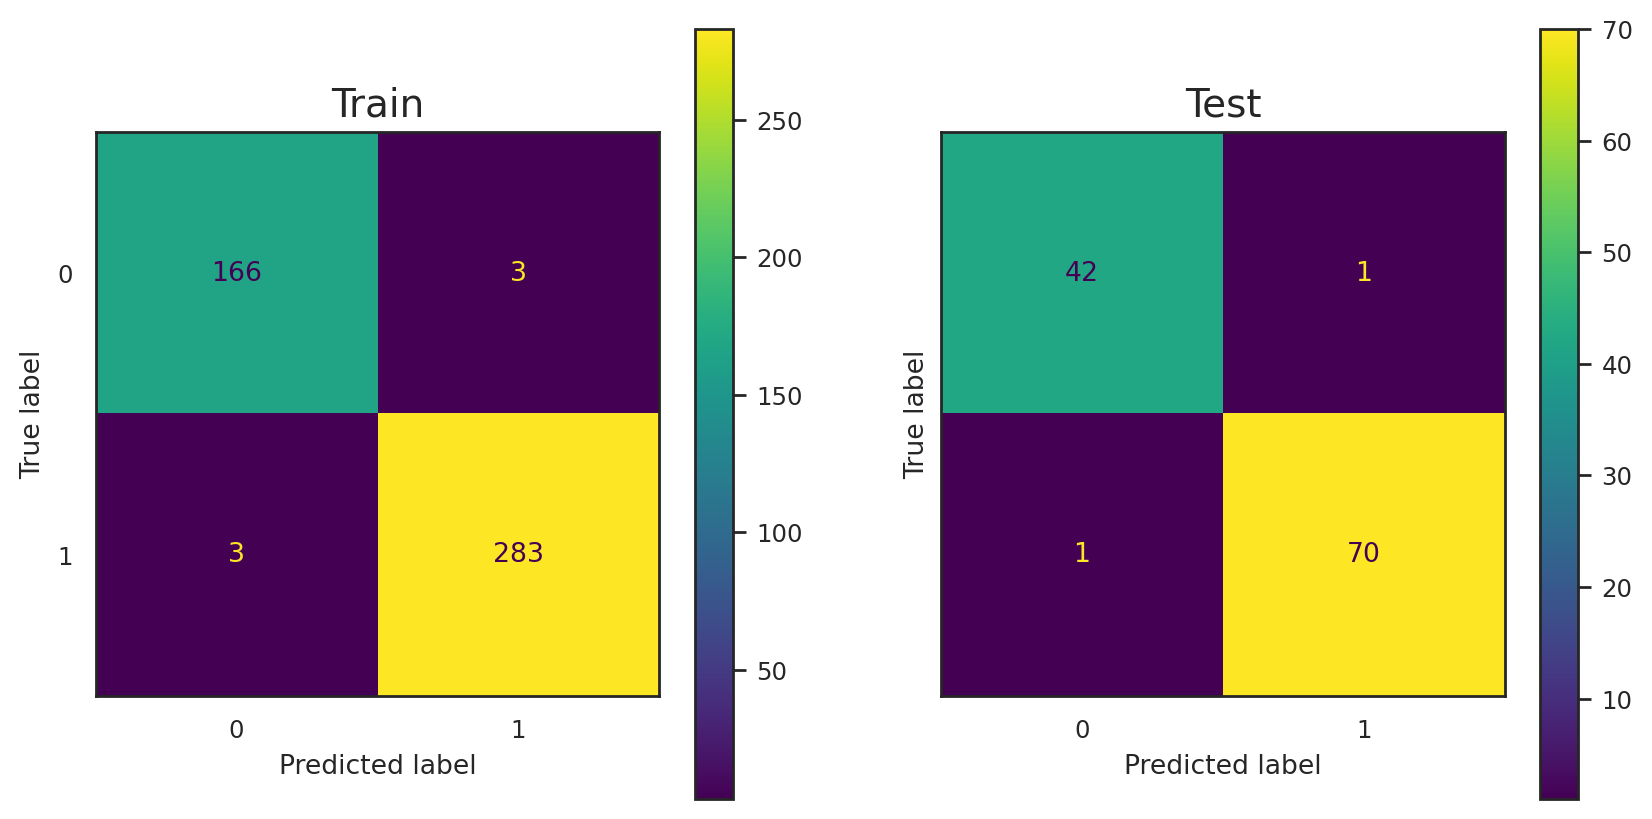

In [ ]:
with sns.axes_style("white"):
  fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
  axs[0].set_title("Train", fontsize=14)
  ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=axs[0])
  axs[1].set_title("Test", fontsize=14)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axs[1])

In [8]:
model = LogisticRegression(penalty=None, fit_intercept=False, tol=1e-3, max_iter=epochs)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scoring = ["accuracy", "recall", "precision"]
scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores_df = pd.DataFrame(
  np.column_stack([scores["test_accuracy"], scores["test_recall"], scores["test_precision"]]),
  columns=["Accuracy", "Recall", "Precision"]
)

In [9]:
scores_df.mean()

Accuracy     0.959235
Recall       0.968365
Precision    0.967281
dtype: float64

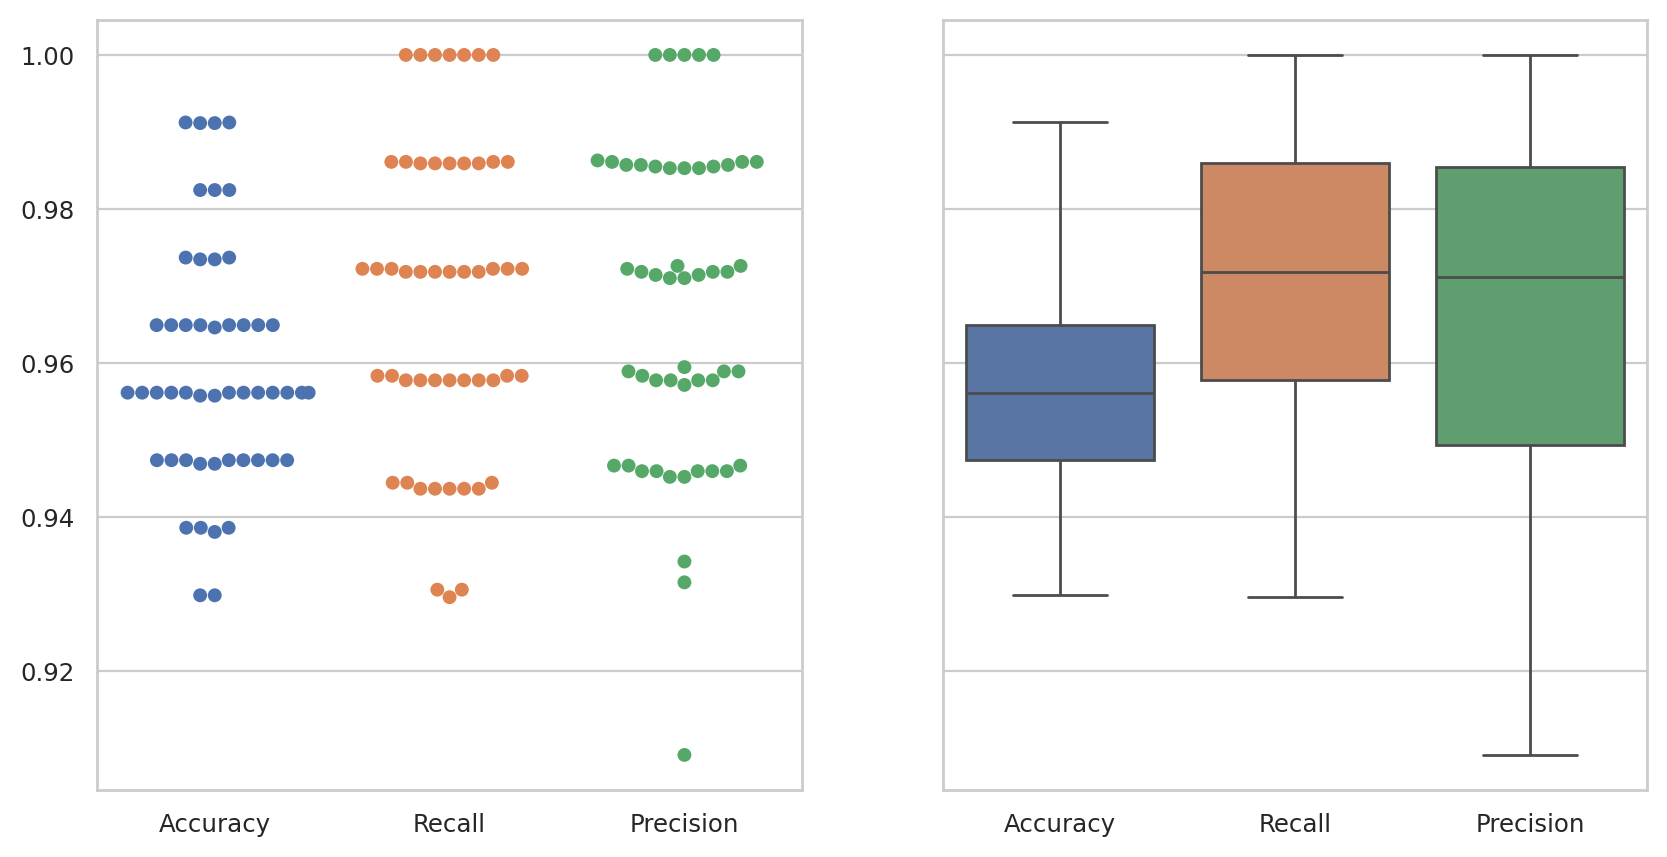

In [ ]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
sns.swarmplot(scores_df, ax=axs[0])
sns.boxplot(scores_df, ax=axs[1])